In [1]:
import numpy as np
import anndata as ad
import pandas as pd
import scanpy as sc
import os
import seaborn as sns
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import gc
gc.enable()
import torch

In [4]:
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=float32,force_device=True'
import cell2location

In [3]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:8000"

In [5]:
loc_prefix="/fs/cbsuvlaminck2/"

os.chdir(f"{loc_prefix}/workdir/dwm269/totalRNA/STRS-HD")

In [6]:
from scripts.py.utils import *
from scripts.py.plots import *

In [47]:
#### TODO Future add this to utils 

def add_spatial_coordinates(adata, csv_path):
    # Read the CSV file containing cell names and coordinates
    spatial_df = pd.read_csv(csv_path, sep='\t', index_col=0, names=['x', 'y'])

    # Merge the spatial information with the original AnnData object
    adata_spatial = pd.merge(adata.obs, spatial_df, left_index=True, right_index=True, how='left')

    # Add NaN for cells without coordinates
    adata_spatial[['x', 'y']] = adata_spatial[['x', 'y']].where(pd.notna(adata_spatial[['x', 'y']]), np.nan)

    # Print a message about the number of cells with added coordinates
    print(f"Added spatial coordinates for {adata_spatial[['x', 'y']].count().min()} cells.")

    # Add the 'spatial' component to the AnnData object
    adata.obsm['spatial'] = adata_spatial[['x', 'y']].values

    return adata

## Settings

Load data

# Run `cell2loc`

# Generate single-cell reference model

## Deconvolution section


In [13]:
adata_ref = sc.read_h5ad('/workdir/in68/Sheep/sc_reference/Rat_ref_sheepgenes.h5ad')

/home/in68/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [11]:
adata_ref.X = adata_ref.raw.X.copy()
del adata_ref.raw
adata_ref.X


ValueError: Data matrix has wrong shape (24882, 20125), need to be (24882, 12285).

In [14]:
from scipy.sparse import csr_matrix
adata_ref.X = csr_matrix(np.round(adata_ref.X).astype(np.int32))


In [15]:
np.unique(adata_ref.obs['cellType'])

array(['Cd74+ Macrophages', 'Fibroblasts', 'Macrophages',
       'PTPRB+ Endothelial', 'SMC', 'T cells', 'Vcam1+ Endothelial',
       'high mito SMC'], dtype=object)

In [16]:
del adata_ref.raw

/home/in68/miniconda3/envs/c2l_backup/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/in68/miniconda3/envs/c2l_backup/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


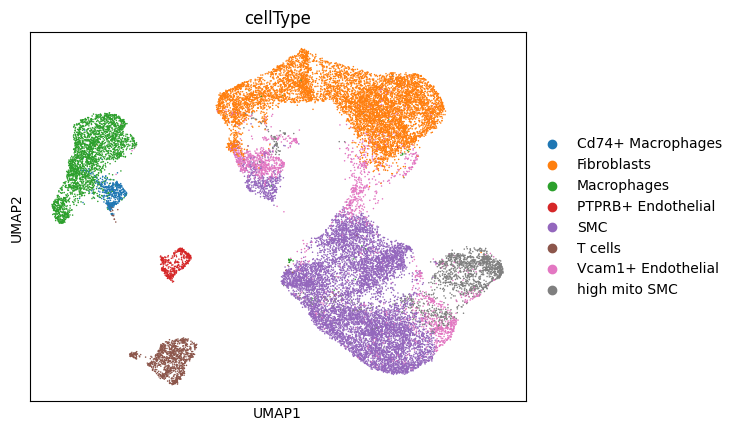

In [17]:
sc.pl.umap(adata_ref,color=['cellType'])

In [23]:
adata_ref.var_names = adata_ref.var_names.astype('str')
adata_ref.var_names_make_unique()

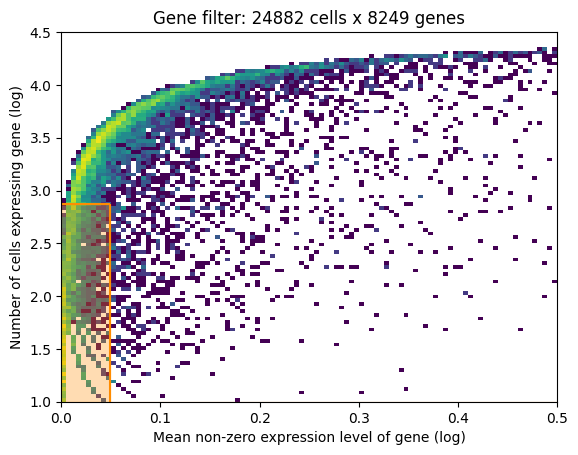

Index(['PPIL4', 'TAB2', 'SHPRH', 'FBXO30', 'EPM2A', 'STX11', 'SF3B5', 'PLAGL1',
       'ZC2HC1B', 'LTV1',
       ...
       'NETO1', 'SALL1', 'KCTD19', 'CALB2', 'BTNL2', 'GRM4', 'TSPEAR', 'AK9',
       'RPS6KA6', 'SLITRK4'],
      dtype='object', name='external_gene_name', length=8249)

In [34]:
from cell2location.utils.filtering import filter_genes
###Standard default vals for heart reference// May requires change for bigger refs
#for adata in ref_dict.values:
selected = filter_genes(
        adata_ref,
        cell_count_cutoff=5,
        cell_percentage_cutoff2=0.03,
        nonz_mean_cutoff=1.12)
selected


In [35]:
# filter the object
adata_ref = adata_ref[:, selected].copy()

In [36]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(
    adata=adata_ref, 
        
    # 10X reaction / sample / batch
    batch_key='orig.ident', 
    
    # cell type, covariate used for constructing signatures
    labels_key='cellType'
    
    # multiplicative technical effects (platform, 3' vs 5', donor effect)
    # categorical_covariate_keys=['Method']
)

/home/in68/miniconda3/envs/c2l_backup/lib/python3.9/abc.py:98: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [37]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref) 

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.4.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'orig.ident',
│   'labels_key': 'cellType',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   8   │
│         n_cells          │ 24882 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   8   │
│          n_vars          │ 8249  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                      batch State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃  Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['orig.ident'] │ controlVessel │          0          │
│                         │  control_6m   │          1          │
│                         │   distal_3m   │          2          │
│                         │   distal_6m   │          3          │
│                         │   graft_3m    │          4          │
│                         │   graft_6m    │          5          │
│                         │  proximal_3m  │          6          │
│                         │  proximal_6m  │          7          │
└─────────────────────────┴───────────────┴─────────────────────┘

                       labels State Registry                        
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃     Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cellType'] │ Cd74+ Macrophages  │          0          │
│                       │    Fibroblasts     │          1          │
│                       │    Macrophages     │          2          │
│                       │ PTPRB+ Endothelial │          3          │
│                       │        SMC         │          4          │
│                       │      T cells       │          5          │
│                       │ Vcam1+ Endothelial │          6          │
│                       │   high mito SMC    │          7          │
└───────────────────────┴────────────────────┴─────────────────────┘

In [38]:
!nvidia-smi

Thu Apr  4 12:27:52 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 27%   26C    P8    21W / 250W |   4589MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:5E:00.0 Off |                  N/A |
| 27%   

In [39]:
mod.train(max_epochs=250, use_gpu=3)

/home/in68/miniconda3/envs/c2l_backup/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
/home/in68/miniconda3/envs/c2l_backup/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/in68/.local/lib/python3.9/site-packages/ipyker ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/in68/miniconda3/envs/c2l_backup/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to r

Epoch 250/250: 100%|█| 250/250 [03:59<00:00,  1.01it/s, v_num=1, elbo_train=1.24

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|█| 250/250 [03:59<00:00,  1.04it/s, v_num=1, elbo_train=1.24


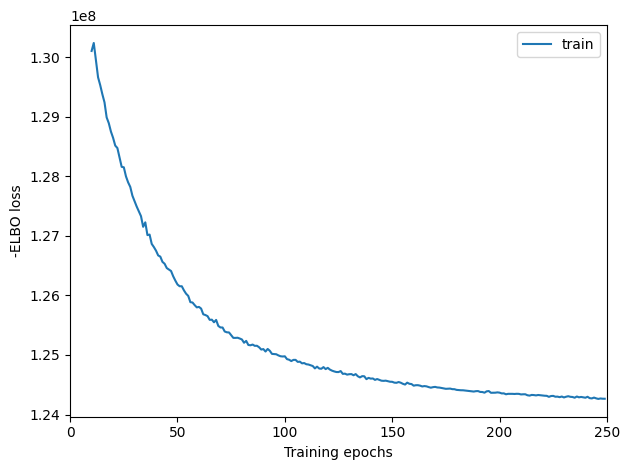

In [40]:
mod.plot_history(10)

In [41]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, 
    sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
ref_run_name = "Sheep_040424"
mod.save(f"/fs/cbsuvlaminck2/workdir/in68/c2l/{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_ref.write( f"/fs/cbsuvlaminck2/workdir/in68/c2l/{ref_run_name}.h5ad")

/home/in68/miniconda3/envs/c2l_backup/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|██████| 999/999 [00:12<00:00, 78.78it/s]


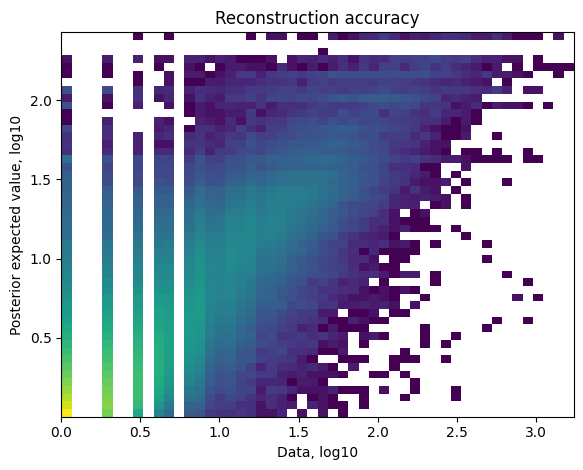

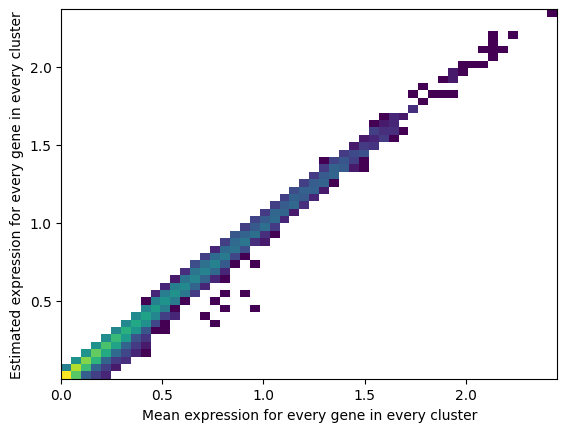

In [42]:
mod.plot_QC()

export estimated expression in each cluster

In [43]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5,20:30 ]

Empty DataFrame
Columns: []
Index: [PPIL4, TAB2, SHPRH, FBXO30, EPM2A]

In [68]:
list_names= ['Brag','Pos','Od','Ct_4']
coords=['/fs/cbsuvlaminck2/workdir/in68/Utils/Curio_BB/B0027_003_BeadBarcodes.txt',
    '/fs/cbsuvlaminck2/workdir/in68/Utils/Curio_BB/B0027_001_BeadBarcodes.txt',
    '/fs/cbsuvlaminck2/workdir/in68/Utils/Curio_BB/B0027_004_BeadBarcodes.txt',        
    '/fs/cbsuvlaminck2/workdir/in68/Utils/Curio_BB/PM111_022_BeadBarcodes.txt']
adata_dict = {}
for i in[0,1,2,3]:
    adata_dict[i] = sc.read_10x_mtx(f"/fs/cbsuvlaminck2/workdir/in68/Graft_Sheep/out/{list_names[i]}/STARsolo/Solo.out/GeneFull/raw")
    adata_dict[i].raw = adata_dict[i].copy()
    sc.pp.filter_cells(adata_dict[i], min_counts = 50)
    adata_dict[i] = add_spatial_coordinates(adata_dict[i],coords[i])
    # adata_dict[i].var["mito"] = adata_dict[i].var_names.str.startswith("Mt-")
    # sc.pp.calculate_qc_metrics(adata_dict[i], qc_vars=["mito"], inplace=True)
    # sc.pp.normalize_total(
    #     adata_dict[i], 
    #     target_sum=1e4)
    # sc.pp.log1p(adata_dict[i])
    # sc.tl.pca(adata_dict[i], svd_solver="arpack")
    # sc.pp.neighbors(adata_dict[i], n_neighbors=10, n_pcs=15)
    # sc.tl.umap(adata_dict[i])

    # sc.tl.leiden(adata_dict[i],resolution=0.1,key_added="leiden1")
    # sc.tl.leiden(adata_dict[i],resolution=0.2,key_added="leiden2")
    # sc.tl.leiden(adata_dict[i],resolution=0.3,key_added="leiden3")
    # clusters = ["leiden1","leiden2","leiden3"]
    # sc.pl.embedding(adata_dict[i],color=clusters,basis="spatial")
    adata_dict[i].obs.index = adata_dict[i].obs.index + f"_{i}"






adata_obj = ad.concat(adatas = [adata_dict[0],adata_dict[1],adata_dict[2],adata_dict[3]], keys=list_names,label = 'batch')

Added spatial coordinates for 51852 cells.
Added spatial coordinates for 5956 cells.
Added spatial coordinates for 78287 cells.
Added spatial coordinates for 2303 cells.


In [69]:
adata_dict[1].obs.index

Index(['AAAACCCGAGTGCT_1', 'AAAACGCCACTCCG_1', 'AAAACGCGAGTTCG_1',
       'AAAACGCTACCCAC_1', 'AAAACGTCTAGATG_1', 'AAAAGACCCATCCC_1',
       'AAACAATAGCTAGC_1', 'AAACACATGTTAAC_1', 'AAACACCGTGTGCT_1',
       'AAACACGATCTGCG_1',
       ...
       'TTTTGCGGTCAGAG_1', 'TTTTGGATTCGTTG_1', 'TTTTGTCAATAGAC_1',
       'TTTTGTTCCATCCA_1', 'TTTTTACAATCCCG_1', 'TTTTTACCTGGGCG_1',
       'TTTTTATTCCGCTA_1', 'TTTTTATTCTCCGC_1', 'TTTTTGGCTGAGAT_1',
       'TTTTTGGTTCGATA_1'],
      dtype='object', length=5956)

In [37]:
# adata_obj = add_spatial_coordinates(adata_obj,
#                                             f"/fs/cbsuvlaminck2/workdir/in68/Utils/Curio_BB/A0018_011_BeadBarcodes.txt")
    
# adata_obj.raw = adata_obj.copy()
min_counts = 20
adata_obj.var["mito"] = adata_obj.var_names.str.startswith("Mt-")
#adata_obj.obsm['MT'] = adata_obj[:, adata_obj.var['mito'].values].X.toarray()
adata_obj = adata_obj[:, ~adata_obj.var['mito'].values]
sc.pp.filter_cells(adata_obj, min_counts = min_counts)

/home/in68/miniconda3/envs/c2l_backup/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:137: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number
/home/in68/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/in68/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/in68/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/in68/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. 

In [70]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_obj.var_names, inf_aver.index)
adata_obj = adata_obj[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_obj)

In [71]:

cell2location.models.Cell2location.setup_anndata(adata=adata_obj, batch_key="batch")
# create and train the model
mod = cell2location.models.Cell2location(
    adata_obj, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=1,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
    
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.4.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'batch',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   4    │
│         n_cells          │ 138398 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │  7783  │
└──────────────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │    Brag    │          0          │
│                    │    Pos     │          1          │
│                    │     Od     │          2          │
│                    │    Ct_4    │          3          │
└────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [51]:
adata_obj.var_names

Index(['A4GALT', 'AAAS', 'AACS', 'AAK1', 'AAR2', 'AARS2', 'AASDH', 'AASDHPPT',
       'AASS', 'ABCA1',
       ...
       'ZSCAN2', 'ZSWIM1', 'ZSWIM3', 'ZSWIM5', 'ZSWIM7', 'ZSWIM8', 'ZW10',
       'ZWINT', 'ZXDC', 'ZYG11B'],
      dtype='object', length=7783)

In [72]:
gc.collect()
mod.train(max_epochs=5000,
          # train using full data (batch_size=None)
          batch_size=6000,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu= 3
         )


/home/in68/miniconda3/envs/c2l_backup/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
/home/in68/miniconda3/envs/c2l_backup/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/in68/.local/lib/python3.9/site-packages/ipyker ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/in68/miniconda3/envs/c2l_backup/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to r

Epoch 5000/5000: 100%|█| 5000/5000 [5:59:40<00:00,  4.37s/it, v_num=1, elbo_trai

`Trainer.fit` stopped: `max_epochs=5000` reached.


Epoch 5000/5000: 100%|█| 5000/5000 [5:59:40<00:00,  4.32s/it, v_num=1, elbo_trai


In [6]:
!nvidia-smi

Wed Apr  3 17:14:08 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 27%   26C    P8    21W / 250W |   6015MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:5E:00.0 Off |                  N/A |
| 27%   

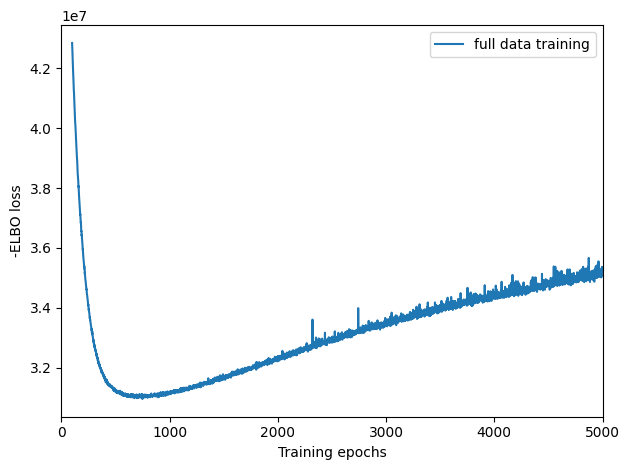

In [73]:
# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(100)
plt.legend(labels=['full data training']);

In [46]:
mod.adata

AnnData object with n_obs × n_vars = 32156 × 14537
    obs: 'n_counts', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'mito'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'spatial'

In [74]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
sample_name = 'Sheep_0405_c2l'

adata_obj = mod.export_posterior(
    adata_obj, sample_kwargs={'num_samples': 1000, 'batch_size': 7000, 'use_gpu': 3}
)

# Save model
#mod.save(f"{sample_name}", overwrite=True)
mod.save(f"/workdir/in68/Muscle/c2l{sample_name}", overwrite = True)



# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"/workdir/in68/Sheep/{sample_name}.h5ad"
adata_obj.write(adata_file)
adata_file

/home/in68/miniconda3/envs/c2l_backup/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|███████████████████████████████████| 999/999 [00:19<00:00, 50.62it/s]


'/workdir/in68/Sheep/Sheep_0405_c2l.h5ad'

In [79]:
list = ['Brag', 'Pos', 'Od', 'Ct_4']
ad = {}
ad[0] = adata_obj[adata_obj.obs['batch'] == list[0]]
ad[1] = adata_obj[adata_obj.obs['batch'] == list[1]]
ad[2] = adata_obj[adata_obj.obs['batch'] == list[2]]
ad[3] = adata_obj[adata_obj.obs['batch'] == list[3]]

In [78]:
adata_obj.obs['batch'] 

AAAAAGGGATATCC_0    Brag
AAAACACCAATGAC_0    Brag
AAAACACGTTGTAA_0    Brag
AAAACAGCGTGCTG_0    Brag
AAAACCGCCATGGC_0    Brag
                    ... 
TTTTGAGCCCGGAT_3    Ct_4
TTTTGCGGGCGGTT_3    Ct_4
TTTTGTCGGACGTG_3    Ct_4
TTTTTTCCGTGTAC_3    Ct_4
TTTTTTTTGACGCA_3    Ct_4
Name: batch, Length: 138398, dtype: category
Categories (4, object): ['Brag', 'Pos', 'Od', 'Ct_4']

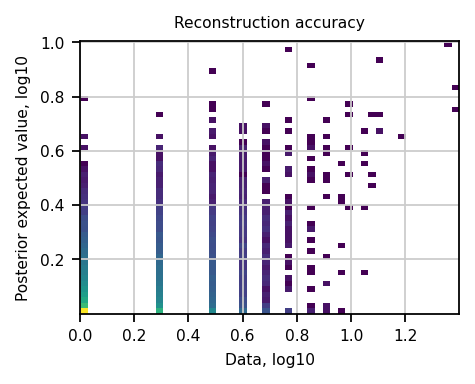

In [89]:
mod.plot_QC()


In [42]:
adata_obj.obsm["spatial"]


array([[2016. , 4646.7],
       [2996. , 3025.8],
       [3120.6, 3660. ],
       ...,
       [3409.9, 2412.3],
       [4301.9, 4035.6],
       [4273.1, 1618.1]])

In [50]:
adata_obj_2 = sc.read_10x_mtx('/fs/cbsuvlaminck2/workdir/in68/Curio/align_out/Sample12/STARsolo/Solo.out/GeneFull/raw/')


In [51]:
adata_obj_2 = add_spatial_coordinates(adata_obj_2,
                                            f"/fs/cbsuvlaminck2/workdir/in68/Utils/Curio_BB/A0018_012_BeadBarcodes.txt")
    
adata_obj_2.raw = adata_obj_2.copy()
min_counts = 20
adata_obj_2.var["mito"] = adata_obj_2.var_names.str.startswith("Mt-")

adata_obj_2 = adata_obj_2[:, ~adata_obj_2.var['mito'].values]
sc.pp.filter_cells(adata_obj_2, min_counts = min_counts)

Added spatial coordinates for 78509 cells.


/home/in68/miniconda3/envs/c2l_backup/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:137: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number


In [52]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_obj_2.var_names, inf_aver.index)
adata_obj_2 = adata_obj_2[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_obj_2)

/home/in68/miniconda3/envs/c2l_backup/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [55]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_obj_2, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=1,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.4.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 22974 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 14537 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [56]:
gc.collect()
mod.train(max_epochs=5000,
          # train using full data (batch_size=None)
          batch_size=6000,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size= 1,
          use_gpu= 3
         )


/home/in68/miniconda3/envs/c2l_backup/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
/home/in68/miniconda3/envs/c2l_backup/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/in68/.local/lib/python3.9/site-packages/ipyker ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/in68/miniconda3/envs/c2l_backup/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to r

Epoch 5000/5000: 100%|█| 5000/5000 [1:38:23<00:00,  1.19s/it, v_num=1, elbo_trai

`Trainer.fit` stopped: `max_epochs=5000` reached.


Epoch 5000/5000: 100%|█| 5000/5000 [1:38:23<00:00,  1.18s/it, v_num=1, elbo_trai


In [54]:
!nvidia-smi

Sun Mar  3 01:16:47 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 27%   25C    P8    15W / 250W |   9368MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:5E:00.0 Off |                  N/A |
| 27%   

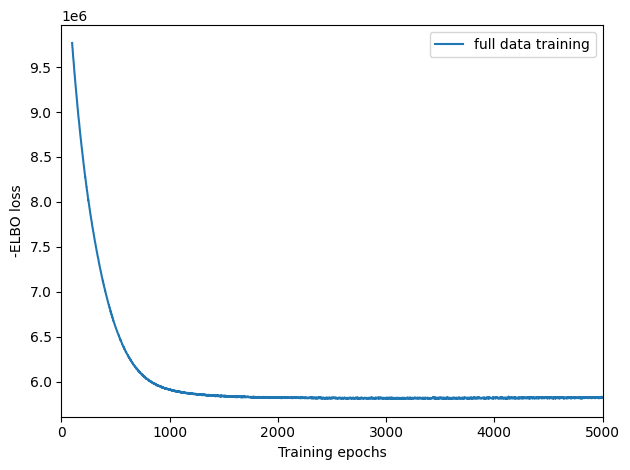

In [57]:
# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(100)
plt.legend(labels=['full data training']);

In [58]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
sample_name = 'Muscle_12_0301'

adata_obj_2 = mod.export_posterior(
    adata_obj_2,  sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': 3}
)

# Save model
#mod.save(f"{sample_name}", overwrite=True)
mod.save(f"/workdir/in68/Muscle/c2l{sample_name}", overwrite = True)



# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"/workdir/in68/Muscle/{sample_name}.h5ad"
adata_obj_2.write(adata_file)
adata_file

/home/in68/miniconda3/envs/c2l_backup/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|██████| 999/999 [01:02<00:00, 16.10it/s]


'/workdir/in68/Muscle/Muscle_12_0301.h5ad'

KeyError: 'spatial'

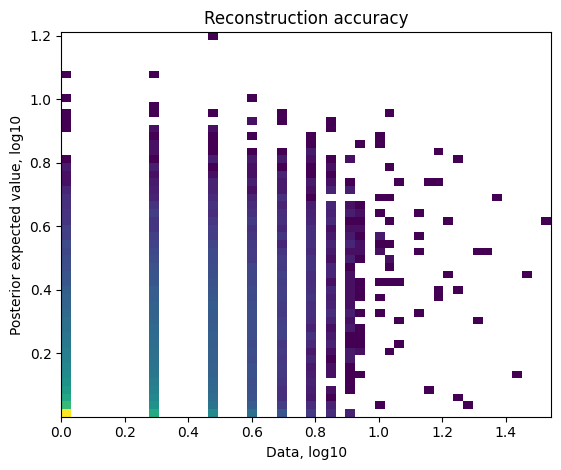

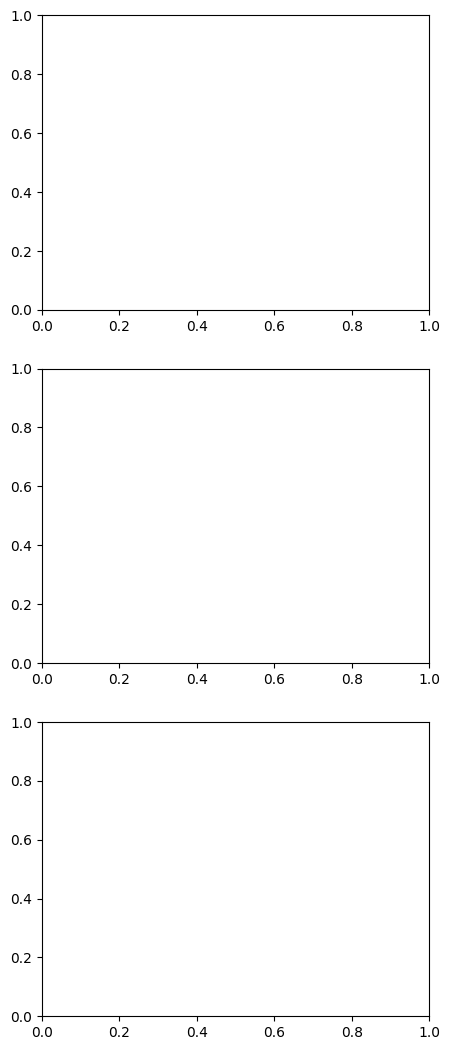

In [59]:
mod.plot_QC()
fig = mod.plot_spatial_QC_across_batches()

KeyError: 10

In [67]:
#####Add Back Spatial location

adata_obj.obs[adata_obj.uns['mod']['factor_names']] = adata_raw.obsm['q05_cell_abundance_w_sf']



sc_cluster_order = ['FAPs (Adipogenic)', 'FAPs (Pro-remodeling)',
       'FAPs (Stem)', 'Fusing Myocytes', 'M1 Macrophages (Ccr2+)',
       'M1/M2 Macrophages (Mrc1+)', 'M2 Macrophages (Cx3cr1+)',
       'Monocytes (Cycling; Cdk1+)', 'Monocytes/Macrophages (Cxcl10+)',
       'Monocytes/Macrophages (Patrolling; Ctsa+)', 'MuSCs 1', 'MuSCs 2',
       'MuSCs 3', 'MuSCs 4', 'MuSCs 5', 'MuSCs 6', 'Myonuclei',
       'NK cells', 'Neutrophils', 'Non-Cycling MPCs',
       'Pericytes and Smooth muscle cells']


sc.settings.set_figure_params(dpi_save= 400, fontsize=7, figsize=(3.0,3.0), facecolor='white', frameon=True, transparent=True, format="pdf")
sc.pl.spatial(adata_obj, color=sc_cluster_order, ncols=7, frameon=False, cmap = 'magma', 
              size=1.5, scale_factor=1.0, hspace=0.1, wspace=0.1,spot_size= 20,
              # limit color scale at 99.2% quantile of cell abundance
              vmin=0, vmax='p99.2'
             )

KeyError: "Values ['B cells', 'Committing MPCs', 'Cycling MPCs', 'Dendritic cells (Cd209a+)', 'Dendritic cells (Cd72+)', 'Dendritic cells (Fscn1+)', 'Dendritic cells (Xcr1+)', 'Endothelial and Myeloid cells', 'Endothelial cells (Artery)', 'Endothelial cells (Capillary)', 'Endothelial cells (Vein)', 'Erythrocytes', 'FAPs (Adipogenic)', 'FAPs (Pro-remodeling)', 'FAPs (Stem)', 'Fusing Myocytes', 'M1 Macrophages (Ccr2+)', 'M1/M2 Macrophages (Mrc1+)', 'M2 Macrophages (Cx3cr1+)', 'Monocytes (Cycling; Cdk1+)', 'Monocytes/Macrophages (Cxcl10+)', 'Monocytes/Macrophages (Patrolling; Ctsa+)', 'MuSCs 1', 'MuSCs 2', 'MuSCs 3', 'MuSCs 4', 'MuSCs 5', 'MuSCs 6', 'Myonuclei', 'NK cells', 'Neutrophils', 'Non-Cycling MPCs', 'Pericytes and Smooth muscle cells', 'Schwann and Neural/Glial cells', 'T cells (Cd4+)', 'T cells (Cycling; Cd3e+)', 'T cells (Non-cycling; Cd3e+)', 'Tenocytes'], from ['B cells', 'Committing MPCs', 'Cycling MPCs', 'Dendritic cells (Cd209a+)', 'Dendritic cells (Cd72+)', 'Dendritic cells (Fscn1+)', 'Dendritic cells (Xcr1+)', 'Endothelial and Myeloid cells', 'Endothelial cells (Artery)', 'Endothelial cells (Capillary)', 'Endothelial cells (Vein)', 'Erythrocytes', 'FAPs (Adipogenic)', 'FAPs (Pro-remodeling)', 'FAPs (Stem)', 'Fusing Myocytes', 'M1 Macrophages (Ccr2+)', 'M1/M2 Macrophages (Mrc1+)', 'M2 Macrophages (Cx3cr1+)', 'Monocytes (Cycling; Cdk1+)', 'Monocytes/Macrophages (Cxcl10+)', 'Monocytes/Macrophages (Patrolling; Ctsa+)', 'MuSCs 1', 'MuSCs 2', 'MuSCs 3', 'MuSCs 4', 'MuSCs 5', 'MuSCs 6', 'Myonuclei', 'NK cells', 'Neutrophils', 'Non-Cycling MPCs', 'Pericytes and Smooth muscle cells', 'Schwann and Neural/Glial cells', 'T cells (Cd4+)', 'T cells (Cycling; Cd3e+)', 'T cells (Non-cycling; Cd3e+)', 'Tenocytes'], are not valid obs/ var names or indices."

/tmp/ipykernel_2754896/3375873492.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad[0].obs[ad[0].uns['mod']['factor_names']] = ad[0].obsm['q05_cell_abundance_w_sf']
/tmp/ipykernel_2754896/3375873492.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad[1].obs[ad[1].uns['mod']['factor_names']] = ad[1].obsm['q05_cell_abundance_w_sf']
/tmp/ipykernel_2754896/3375873492.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad[2].obs[ad[2].uns['mod']['factor_names']] = ad[2].obsm['q05_cell_abundance_w_sf']
/tmp/ipykernel_2754896/3375873492.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad[3].obs[ad[3].uns['mod']['factor_names']] = ad[3].obsm['q05_cell_abundance_w_sf']


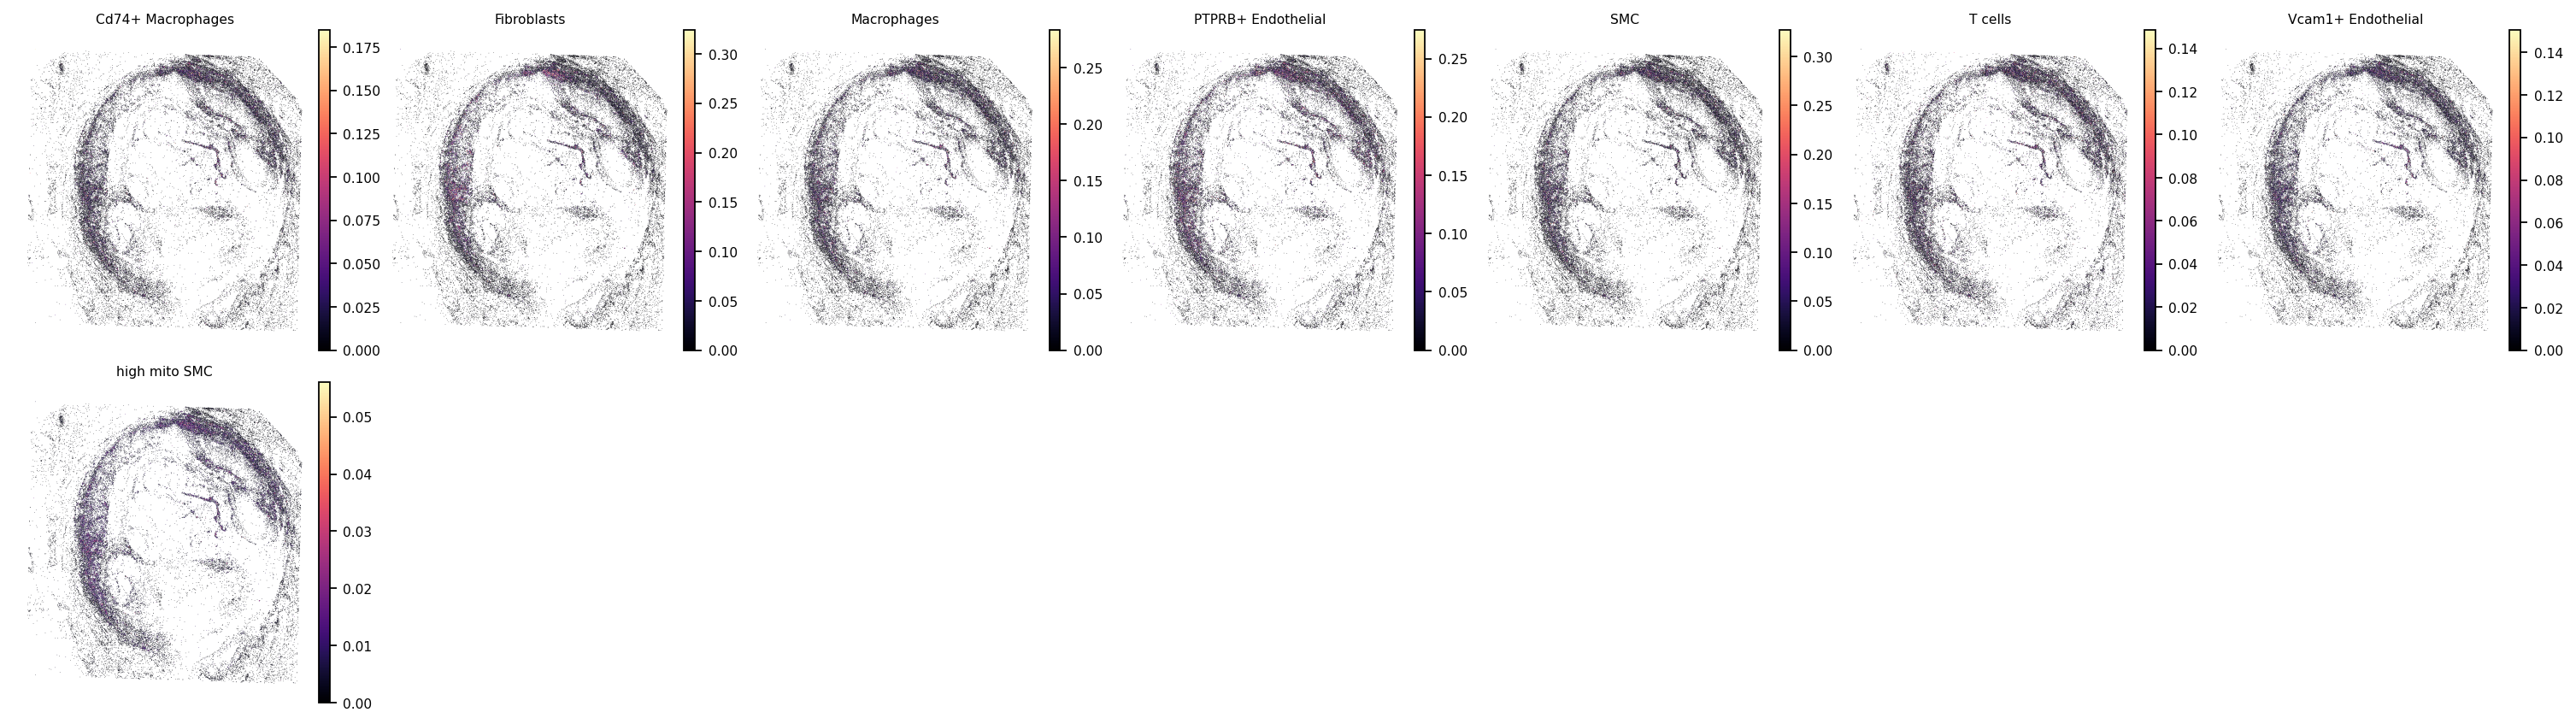

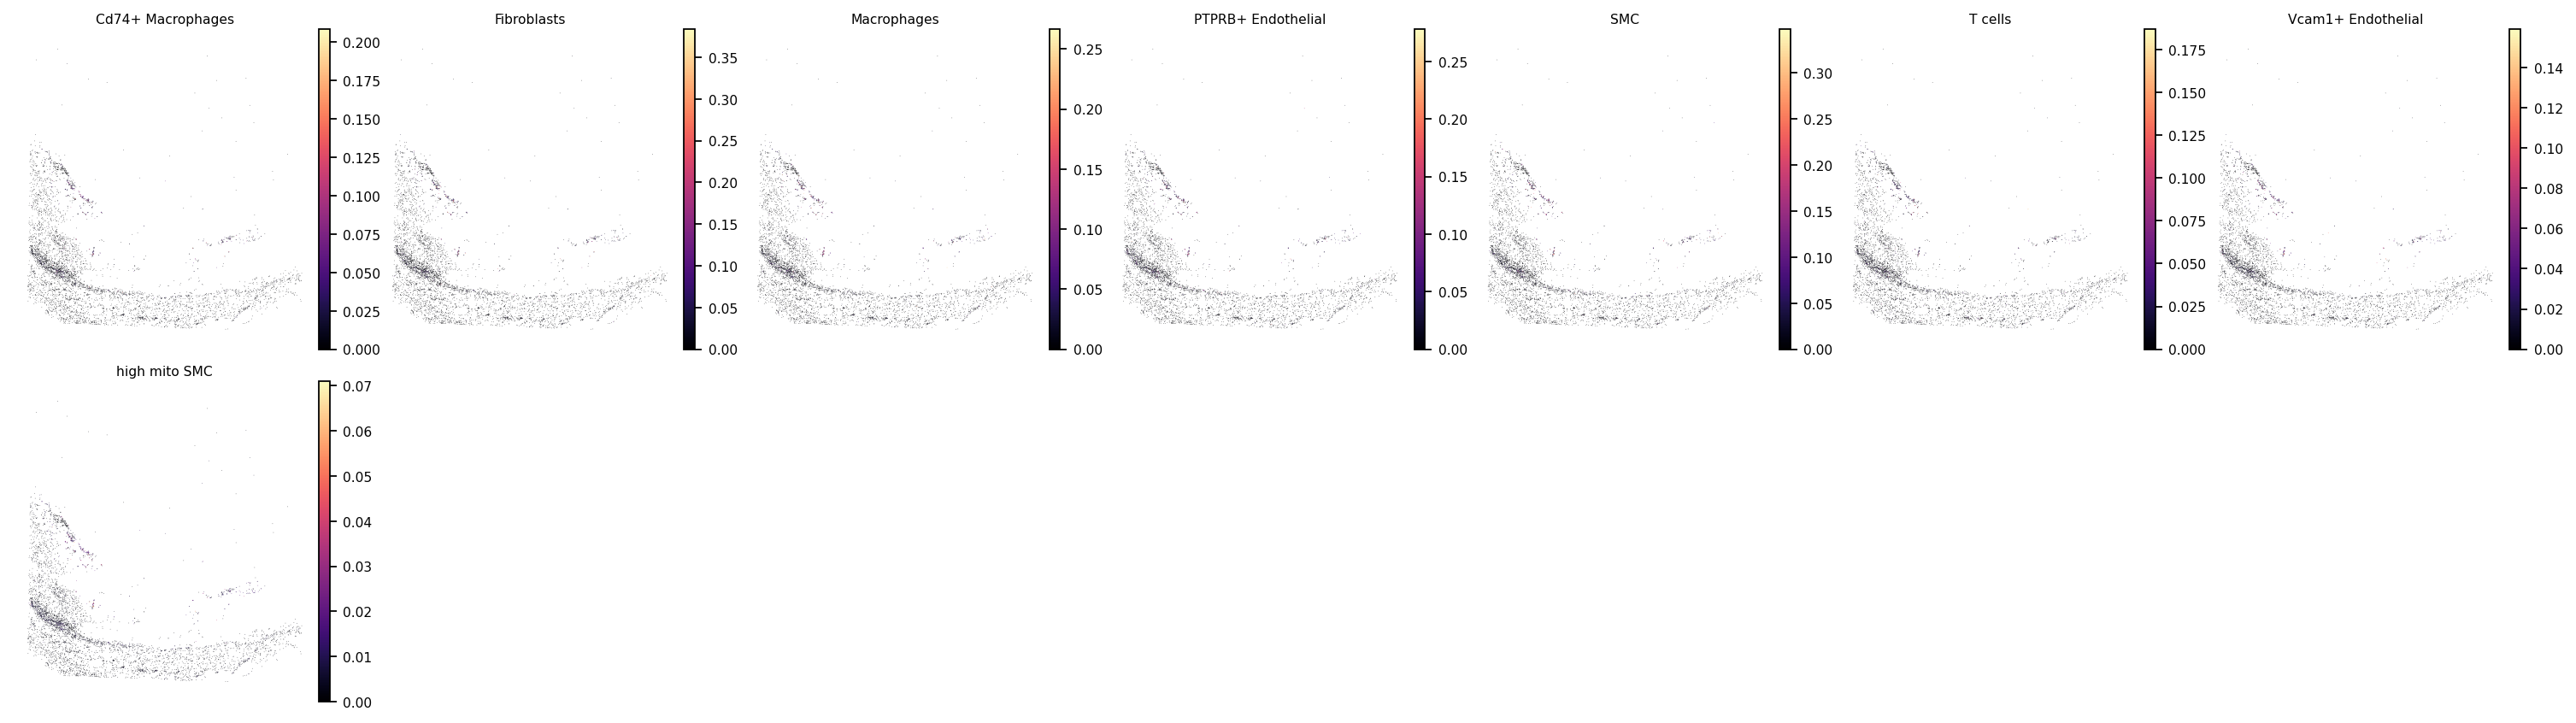

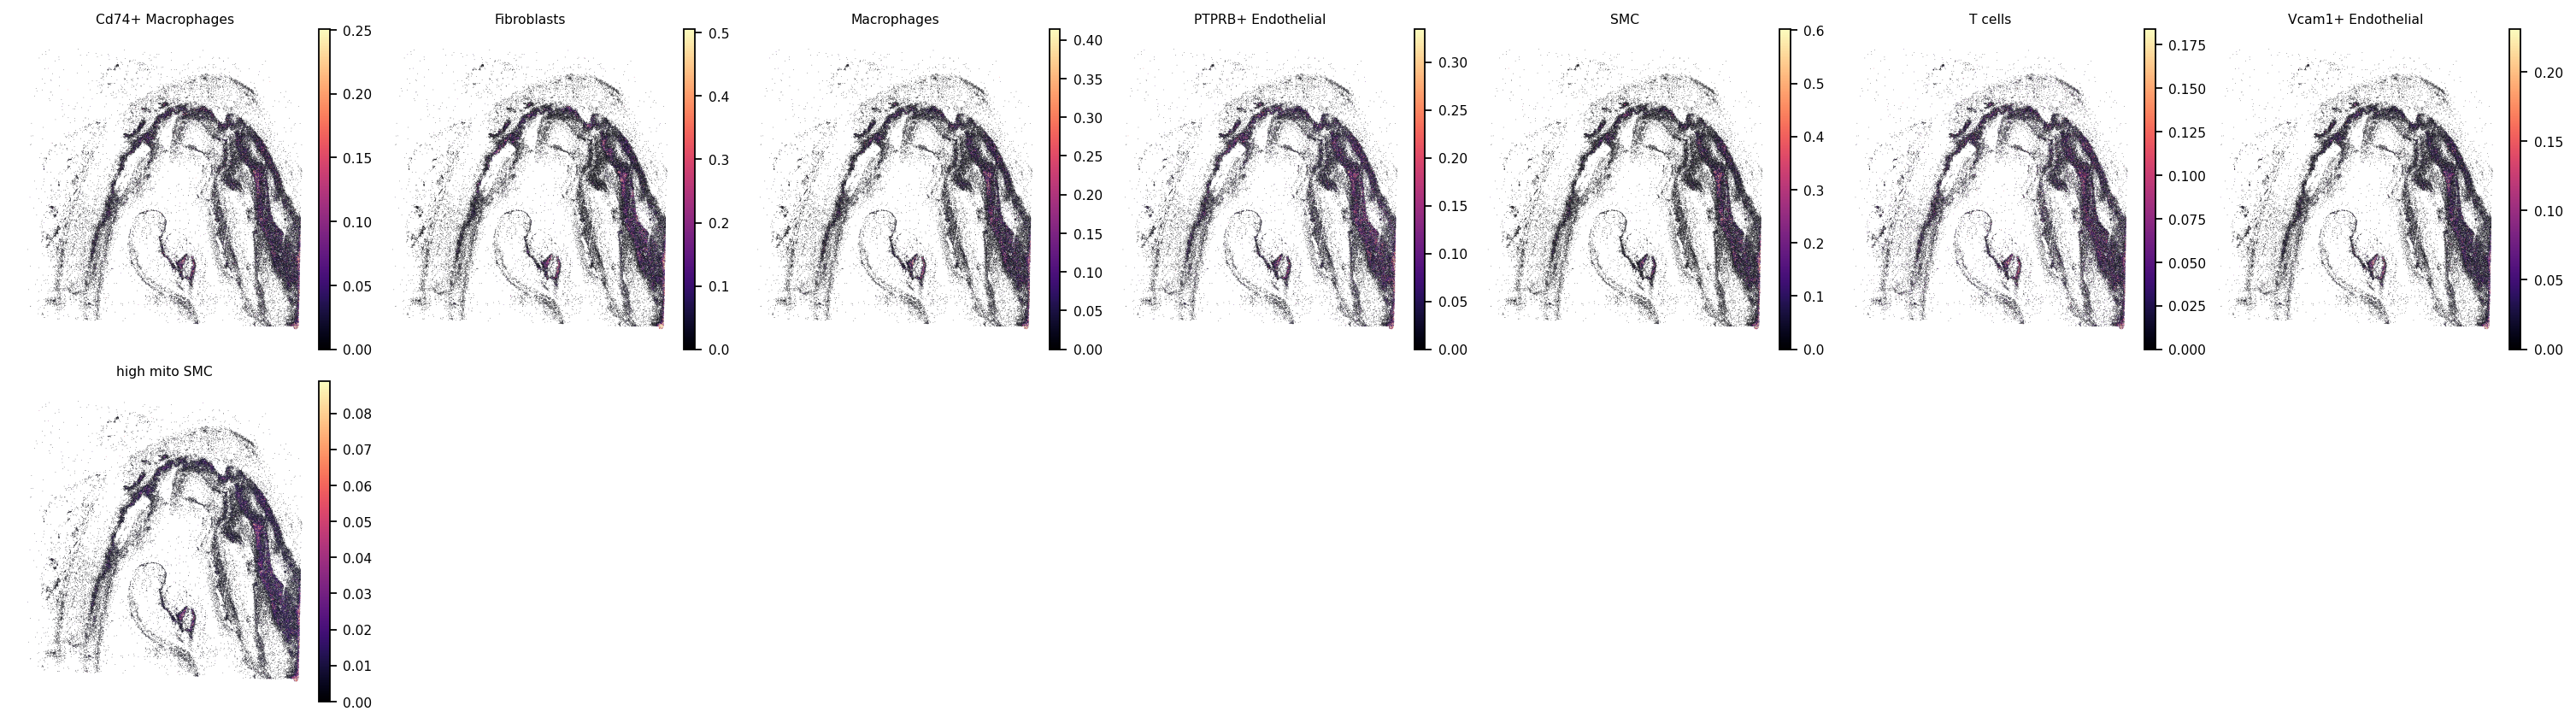

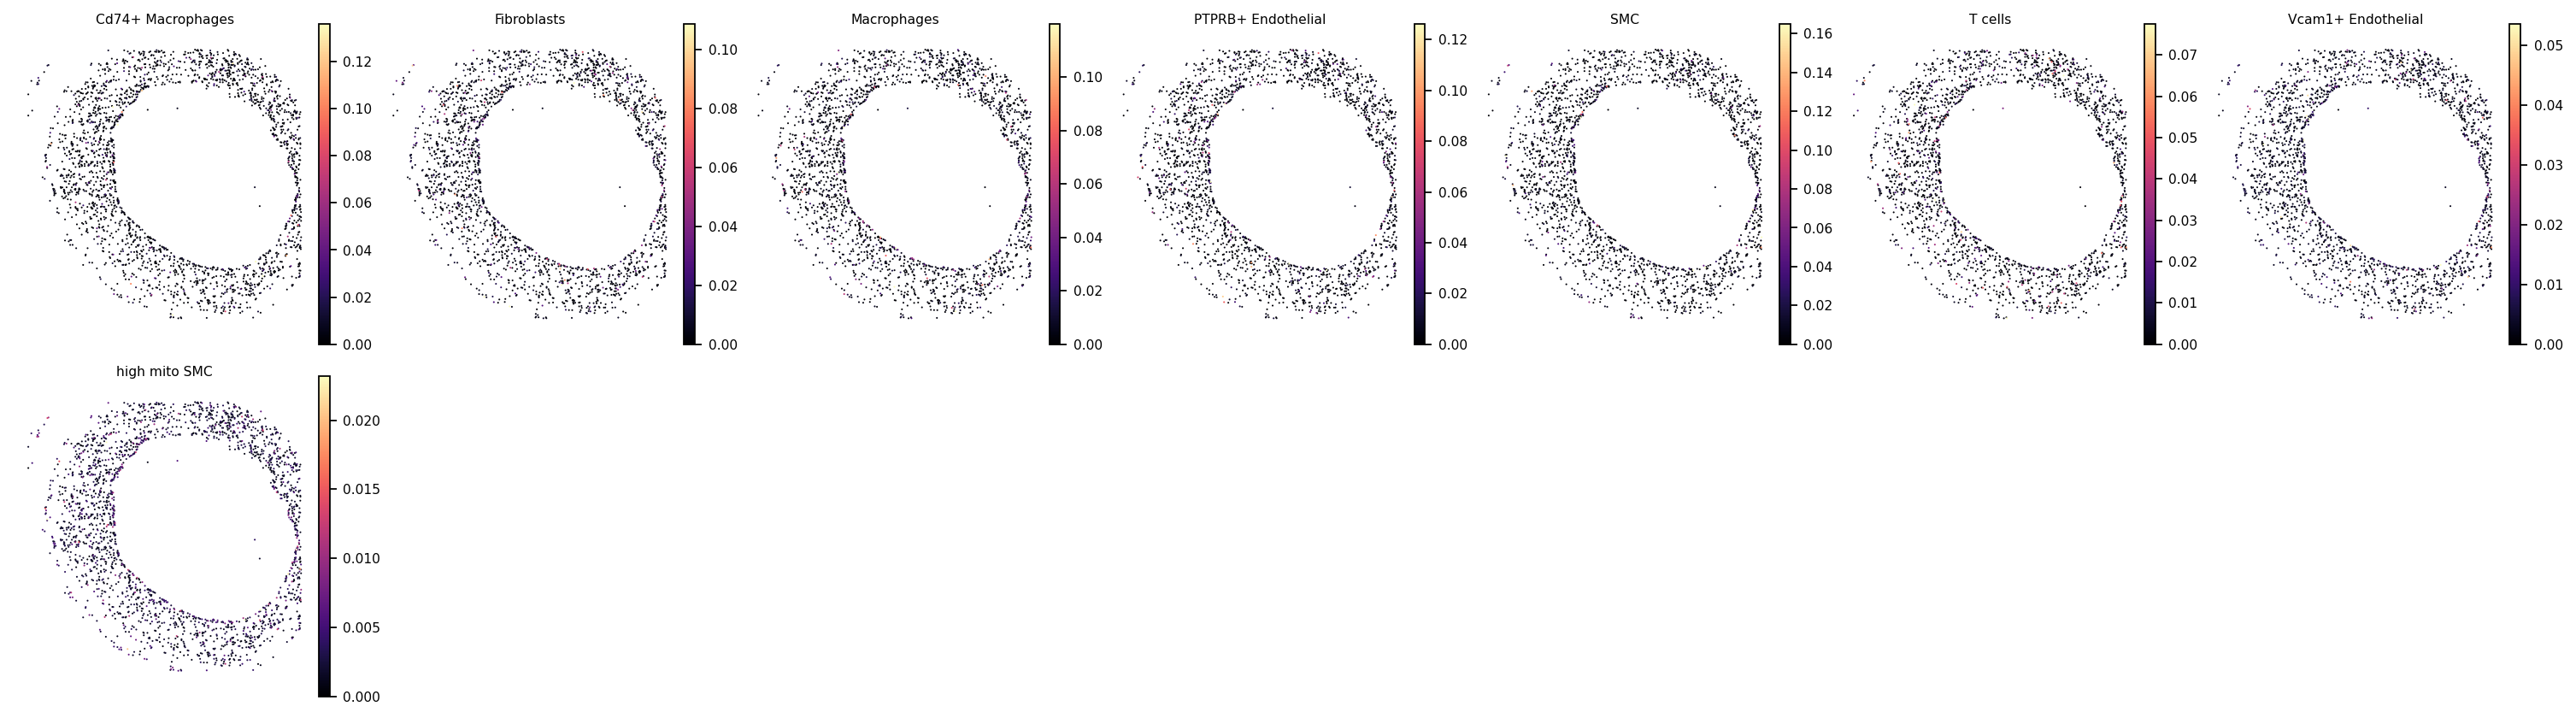

In [81]:
sc_cluster_order = ['Cd74+ Macrophages','Fibroblasts','Macrophages','PTPRB+ Endothelial','SMC','T cells','Vcam1+ Endothelial','high mito SMC']

ad[0].obs[ad[0].uns['mod']['factor_names']] = ad[0].obsm['q05_cell_abundance_w_sf']
ad[1].obs[ad[1].uns['mod']['factor_names']] = ad[1].obsm['q05_cell_abundance_w_sf']
ad[2].obs[ad[2].uns['mod']['factor_names']] = ad[2].obsm['q05_cell_abundance_w_sf']
ad[3].obs[ad[3].uns['mod']['factor_names']] = ad[3].obsm['q05_cell_abundance_w_sf']




sc.settings.set_figure_params(dpi_save= 400, fontsize=7, figsize=(3.0,3.0), facecolor='white', frameon=True, transparent=True, format="pdf")
sc.pl.spatial(ad[0], color=sc_cluster_order, ncols=7, frameon=False, cmap = 'magma', 
              size=1.5, scale_factor=1.0, hspace=0.1, wspace=0.1,spot_size= 20,
              # limit color scale at 99.2% quantile of cell abundance
              vmin=0, vmax='p99'
             )
sc.pl.spatial(ad[1], color=sc_cluster_order, ncols=7, frameon=False, cmap = 'magma', 
              size=1.5, scale_factor=1.0, hspace=0.1, wspace=0.1,spot_size= 20,
              # limit color scale at 99.2% quantile of cell abundance
              vmin=0, vmax='p99'
             )
sc.pl.spatial(ad[2], color=sc_cluster_order, ncols=7, frameon=False, cmap = 'magma', 
              size=1.5, scale_factor=1.0, hspace=0.1, wspace=0.1,spot_size= 20,
              # limit color scale at 99.2% quantile of cell abundance
              vmin=0, vmax='p99'
             )
sc.pl.spatial(ad[3], color=sc_cluster_order, ncols=7, frameon=False, cmap = 'magma', 
              size=1.5, scale_factor=1.0, hspace=0.1, wspace=0.1,spot_size= 50,
              # limit color scale at 99.2% quantile of cell abundance
              vmin=0, vmax='p99'
             )

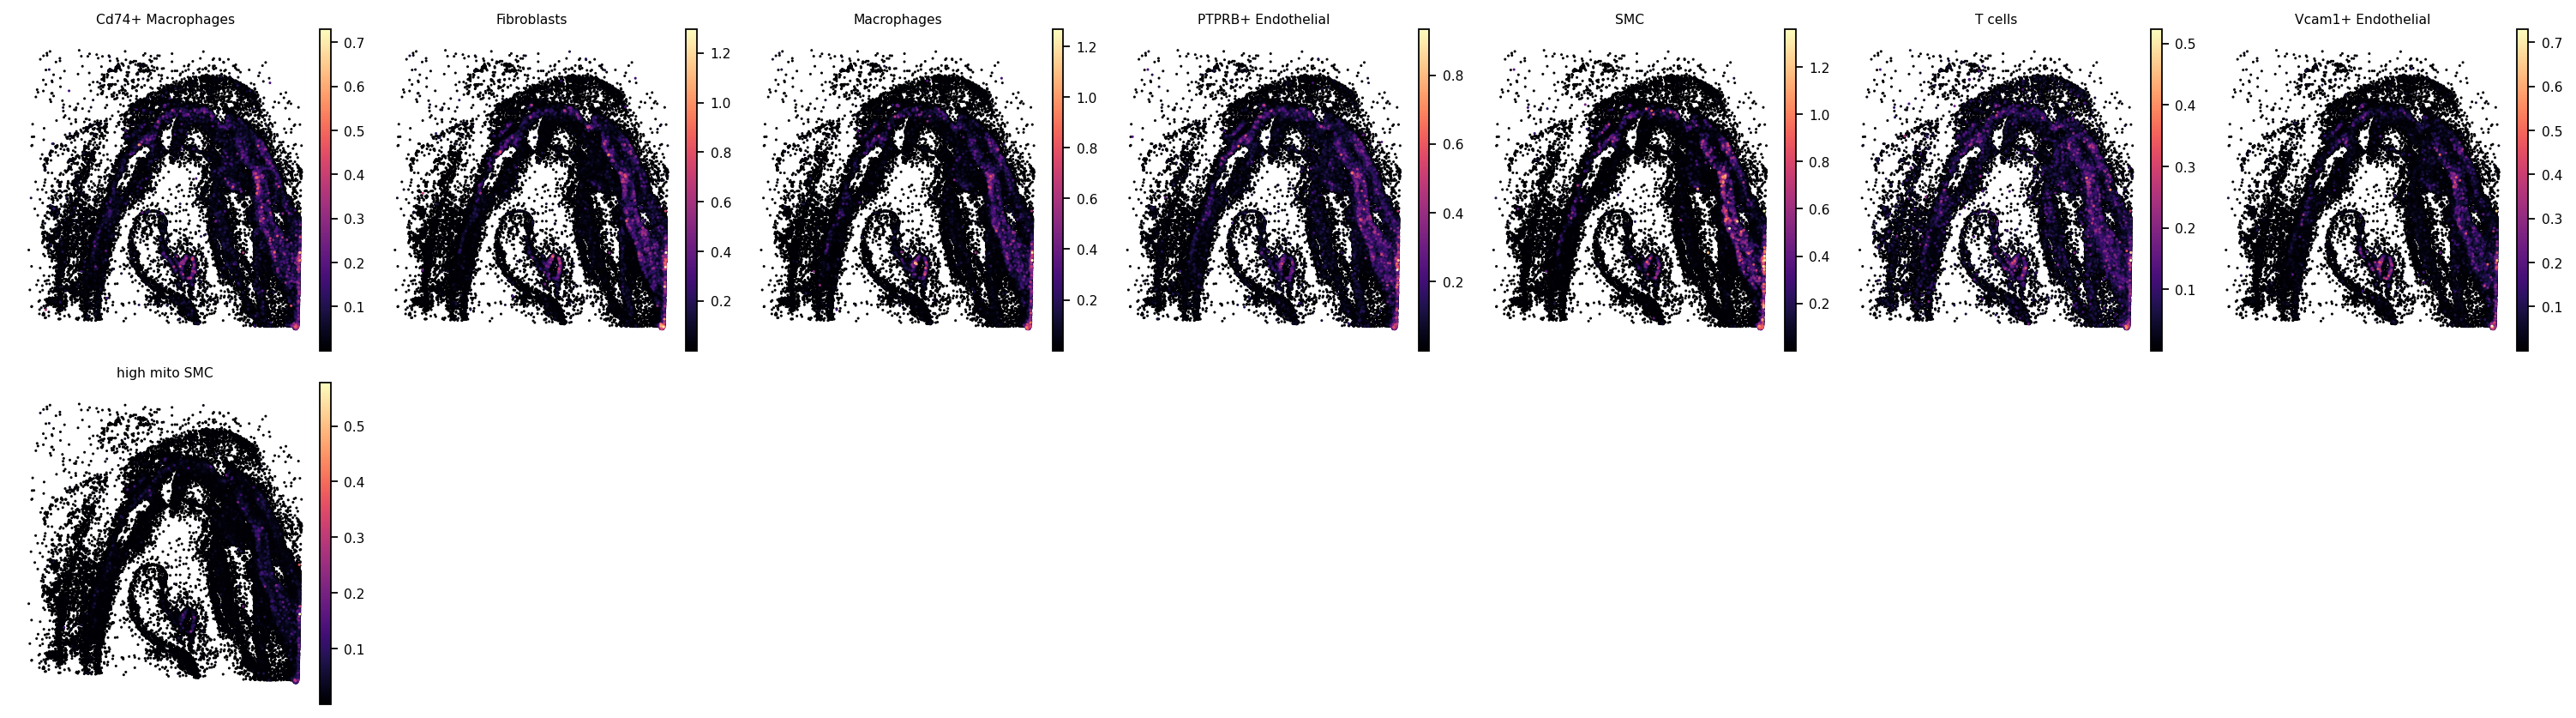

In [88]:
sc.pl.spatial(ad[2], color=sc_cluster_order, ncols=7, frameon=False, cmap = 'magma', 
              size=1.5, scale_factor=1.0, hspace=0.1, wspace=0.1,spot_size= 100,
              # limit color scale at 99.2% quantile of cell abundance

              
             )